In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
import re
import torch
from torch_geometric.data import Data, Batch

from Bio.PDB import PDBList, PDBParser, PPBuilder
from Bio import PDB

import networkx as nx
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphConv, GraphSAGE

import random

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from ydata_profiling import ProfileReport
import os
from scipy.stats import pearsonr


In [2]:
# 固定随机种子等操作
seed = 12345
print('seed is ' + str(seed))
g = torch.Generator()
g.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。


seed is 12345


# 1. read CheMBL datasets

In [3]:
raw_data_molecule = pd.read_csv('./data/raw_data_Neprilysin_BindingDB.tsv', sep='\t')
# raw_data_molecule = pd.read_csv('./data/raw_data_Neprilysin_BindingDB.tsv', sep='\t')
raw_data_molecule = raw_data_molecule.sample(frac=1, random_state=seed)
raw_data_molecule.reset_index(drop=True, inplace=True)
raw_data_molecule.head(5)

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain
0,50799484,OC(=O)[C@H](Cc1ccc2c(c1)oc1ccccc21)NC(CCc1cccc...,InChI=1S/C28H26NO6P/c30-28(31)24(16-18-12-14-2...,RBOBZHFYMPJNHQ-BXXZMZEQSA-N,50084907,3-Dibenzofuran-3-yl-2-(3-naphthalen-1-yl-1-pho...,Neprilysin,Rattus norvegicus,NaN,13770,...,Neprilysin,NEP_RAT,P07861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50277004,OC(=O)CNC(=O)[C@@H](C[C@@H](COc1ccccc1)C(O)=O)...,InChI=1S/C27H27NO6/c29-25(30)17-28-26(31)22(16...,CXWNRJVOFAKQLW-PKTZIBPZSA-N,50286906,"(2S,4S)-5-Biphenyl-4-yl-4-(carboxymethyl-carba...",Neprilysin,Rattus norvegicus,NaN,3.2,...,Neprilysin,NEP_RAT,P07861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,571369,CCOC(=O)[C@@H](CN(Cc1ccc(Br)cc1)NC(=O)C(=O)OCC...,InChI=1S/C20H25BrN2O9/c1-4-29-17(25)15(32-20(2...,BRKMRNSILIJOQW-OAHLLOKOSA-N,298322,"US10123984, Example 14A::US10123984, Example 1...",Neprilysin,NaN,3.55,NaN,...,Neprilysin,NEP_HUMAN,P08473,A8K6U6 D3DNJ9 Q3MIX4,NaN,NaN,NaN,NaN,NaN,NaN
3,50045829,CC[C@@H](C)[C@H](S)C(=O)N[C@@H](C(C)c1ccccc1)C...,InChI=1S/C25H32N2O5S/c1-4-15(2)22(33)24(30)27-...,NRYHNFJZVXIWQC-UKIQKLBQSA-N,50369210,CHEMBL1794011,Neprilysin,Oryctolagus cuniculus,NaN,32,...,Neprilysin,NEP_RABIT,P08049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50076676,CCC(C)C(NC(=O)[C@@H](CC(=O)NO)Cc1ccccc1)C(=O)N...,InChI=1S/C22H33N3O6/c1-5-14(4)19(21(28)23-18(1...,IEVZTPJUFMSHHO-UOBIKFCOSA-N,50047222,2-[2-(2-Benzyl-3-hydroxycarbamoyl-propionylami...,Neprilysin,Rattus norvegicus,58,NaN,...,Neprilysin,NEP_RAT,P07861,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(raw_data_molecule.columns)

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)',
       'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number',
       'Authors', 'Institution', 'Link to Ligand in BindingDB',
       'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB',
       'PDB ID(s) for Ligand-Target Complex', 'PubChem CID of Ligand',
       'PubChem SID of Ligand', 'ChEBI ID of Ligand', 'ChEMBL ID of Ligand',
       'DrugBank ID of Ligand', 'IUPHAR_GRAC ID of Ligand',
       'KEGG ID of Ligand', 'ZINC ID of Ligand',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequ

In [5]:
raw_data_molecule_copy = raw_data_molecule.dropna(subset=['BindingDB Reactant_set_id', 'Ligand SMILES', 'IC50 (nM)'])
raw_data_molecule_copy = raw_data_molecule_copy[['BindingDB Reactant_set_id', 'IC50 (nM)', 'Ligand SMILES', 'ChEMBL ID of Ligand']].reset_index(drop=True)
raw_data_molecule_copy

,BindingDB Reactant_set_id,IC50 (nM),Ligand SMILES,ChEMBL ID of Ligand
0,50799484,13770,OC(=O)[C@H](Cc1ccc2c(c1)oc1ccccc21)NC(CCc1cccc...,CHEMBL357251
1,50277004,3.2,OC(=O)CNC(=O)[C@@H](C[C@@H](COc1ccccc1)C(O)=O)...,CHEMBL34884
2,50045829,32,CC[C@@H](C)[C@H](S)C(=O)N[C@@H](C(C)c1ccccc1)C...,CHEMBL1794011
3,50674159,3.00,OC(=O)C1CCCCCCC(CS)C(=O)N1,CHEMBL333720
4,50093689,67,OC(=O)[C@@H]1Cc2ccccc2CCCCCC[C@H](CS)C(=O)N1,CHEMBL147755
...,...,...,...,...
1207,50674152,3,OC(=O)C1CCCCCCC(CS)C(=O)N1,CHEMBL333720
1208,51295272,8.0,CS(=O)(=O)N[C@@H](CCCCN)C(=O)NC[C@H](CC1(CCCC1...,CHEMBL42583
1209,50725317,366,CCCC[C@H](C[C@H](Cc1ccc(cc1)-n1cccn1)C(=O)NCC(...,CHEMBL159884
1210,50776511,1.2,OC(=O)[C@@H]1CC[C@@H](N1C(=O)CNC(=O)C(S)Cc1ccc...,CHEMBL327454


In [6]:
raw_data_molecule_copy.isna().sum()

BindingDB Reactant_set_id      0
IC50 (nM)                      0
Ligand SMILES                  0
ChEMBL ID of Ligand          125
dtype: int64

In [7]:
raw_data_molecule_copy.nunique()

BindingDB Reactant_set_id    1212
IC50 (nM)                     457
Ligand SMILES                1003
ChEMBL ID of Ligand           891
dtype: int64

In [8]:
raw_data_molecule_copy = raw_data_molecule_copy.drop_duplicates(subset='Ligand SMILES')
raw_data_molecule_copy = raw_data_molecule_copy.reset_index(drop=True)

In [9]:
value_list = []
raw_data_molecule_copy_copy = raw_data_molecule_copy.copy()

for idx, data in enumerate(raw_data_molecule_copy_copy['IC50 (nM)']):
    if data.startswith(r'>'):
        data = data.split('>')[1]
        value_list.append(data)
    elif data.startswith(r'<'):
        data = data.split('<')[1]
        value_list.append(data)
    else:
        value_list.append(data)
        # raw_data_molecule_copy_copy.drop(index=idx, inplace=True)

value = pd.Series(value_list, name='IC50 (nM)')

raw_data_molecule_copy_copy['IC50 (nM)'] = value
raw_data_molecule_copy_copy
raw_data_molecule_copy = raw_data_molecule_copy_copy
raw_data_molecule_copy

,BindingDB Reactant_set_id,IC50 (nM),Ligand SMILES,ChEMBL ID of Ligand
0,50799484,13770,OC(=O)[C@H](Cc1ccc2c(c1)oc1ccccc21)NC(CCc1cccc...,CHEMBL357251
1,50277004,3.2,OC(=O)CNC(=O)[C@@H](C[C@@H](COc1ccccc1)C(O)=O)...,CHEMBL34884
2,50045829,32,CC[C@@H](C)[C@H](S)C(=O)N[C@@H](C(C)c1ccccc1)C...,CHEMBL1794011
3,50674159,3.00,OC(=O)C1CCCCCCC(CS)C(=O)N1,CHEMBL333720
4,50093689,67,OC(=O)[C@@H]1Cc2ccccc2CCCCCC[C@H](CS)C(=O)N1,CHEMBL147755
...,...,...,...,...
998,50012901,1.7,[O-]S(=O)(=O)c1ccc(NC(=O)C(CS)Cc2ccccc2)cc1,CHEMBL154774
999,50724132,2.6,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1[C@@H]...,CHEMBL50582
1000,50352854,195,CCCC(CC1(CCCC1)C(=O)N[C@@H]1CCCC[C@@H]1Cc1cccc...,CHEMBL213404
1001,50725317,366,CCCC[C@H](C[C@H](Cc1ccc(cc1)-n1cccn1)C(=O)NCC(...,CHEMBL159884


In [10]:
change_type = raw_data_molecule_copy['IC50 (nM)'].astype('float32')
raw_data_molecule_copy['IC50 (nM)'] = change_type

In [11]:
raw_data_molecule_copy['pIC50'] = raw_data_molecule_copy['IC50 (nM)'].apply(lambda x: -np.log10(x * 10 ** (-9)))

In [12]:
raw_data_molecule_copy = raw_data_molecule_copy[raw_data_molecule_copy['pIC50'] >= 4.0]

In [13]:
raw_data_molecule = raw_data_molecule_copy.reset_index(drop=True)
print(raw_data_molecule.isna().sum())
print(raw_data_molecule.nunique())
raw_data_molecule

BindingDB Reactant_set_id      0
IC50 (nM)                      0
Ligand SMILES                  0
ChEMBL ID of Ligand          112
pIC50                          0
dtype: int64
BindingDB Reactant_set_id    993
IC50 (nM)                    393
Ligand SMILES                993
ChEMBL ID of Ligand          881
pIC50                        393
dtype: int64


,BindingDB Reactant_set_id,IC50 (nM),Ligand SMILES,ChEMBL ID of Ligand,pIC50
0,50799484,13770.0,OC(=O)[C@H](Cc1ccc2c(c1)oc1ccccc21)NC(CCc1cccc...,CHEMBL357251,4.861066
1,50277004,3.2,OC(=O)CNC(=O)[C@@H](C[C@@H](COc1ccccc1)C(O)=O)...,CHEMBL34884,8.494850
2,50045829,32.0,CC[C@@H](C)[C@H](S)C(=O)N[C@@H](C(C)c1ccccc1)C...,CHEMBL1794011,7.494850
3,50674159,3.0,OC(=O)C1CCCCCCC(CS)C(=O)N1,CHEMBL333720,8.522879
4,50093689,67.0,OC(=O)[C@@H]1Cc2ccccc2CCCCCC[C@H](CS)C(=O)N1,CHEMBL147755,7.173925
...,...,...,...,...,...
988,50012901,1.7,[O-]S(=O)(=O)c1ccc(NC(=O)C(CS)Cc2ccccc2)cc1,CHEMBL154774,8.769551
989,50724132,2.6,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1[C@@H]...,CHEMBL50582,8.585027
990,50352854,195.0,CCCC(CC1(CCCC1)C(=O)N[C@@H]1CCCC[C@@H]1Cc1cccc...,CHEMBL213404,6.709965
991,50725317,366.0,CCCC[C@H](C[C@H](Cc1ccc(cc1)-n1cccn1)C(=O)NCC(...,CHEMBL159884,6.436519


# 2. construct graphs for small molecules

In [14]:
# Define possible values for one-hot encoding
possible_atomic_numbers = list(range(1, 119))
possible_degrees = list(range(0, 10))
possible_hybridizations = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_chirality = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
possible_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                       Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

possible_bond_stereo = [Chem.rdchem.BondStereo.STEREONONE, Chem.rdchem.BondStereo.STEREOZ,
                        Chem.rdchem.BondStereo.STEREOE, Chem.rdchem.BondStereo.STEREOCIS,
                        Chem.rdchem.BondStereo.STEREOTRANS]

# One-hot encoding functions
def one_hot_encode(value, possible_values):
    encoding = [0] * len(possible_values)
    if value in possible_values:
        encoding[possible_values.index(value)] = 1
    return encoding

# Functions for molecular data processing
def get_atomic_info(atom):
    atomic_number_encoding = one_hot_encode(atom.GetAtomicNum(), possible_atomic_numbers)
    degree_encoding = one_hot_encode(atom.GetTotalDegree(), possible_degrees)
    hybridization_encoding = one_hot_encode(atom.GetHybridization(), possible_hybridizations)
    aromatic_encoding = [1 if atom.GetIsAromatic() else 0]
    implicit_valence_encoding = one_hot_encode(atom.GetImplicitValence(), possible_degrees)
    formal_charge_encoding = [atom.GetFormalCharge()]
    chirality_encoding = one_hot_encode(atom.GetChiralTag(), possible_chirality)

    return atomic_number_encoding + degree_encoding + hybridization_encoding + \
           aromatic_encoding + implicit_valence_encoding + formal_charge_encoding + chirality_encoding

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = [get_atomic_info(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edges = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))

        bond_type_encoding = one_hot_encode(bond.GetBondType(), possible_bond_types)
        bond_stereo_encoding = one_hot_encode(bond.GetStereo(), possible_bond_stereo)
        conjugation_encoding = [1 if bond.GetIsConjugated() else 0]
        edge_feature = bond_type_encoding + bond_stereo_encoding + conjugation_encoding

        edge_features.append(edge_feature)
        edge_features.append(edge_feature)

    edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [15]:
graph_list = [smiles_to_graph(smile) for smile in raw_data_molecule['Ligand SMILES']]
pIC50_list = raw_data_molecule['pIC50'].to_list()

scaler = StandardScaler()
pIC50_list = scaler.fit_transform(np.array(pIC50_list).reshape(-1, 1)).flatten()

for graph, pIC50 in zip(graph_list, pIC50_list):
    graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)


drug_graphs = graph_list
drug_graphs[0]


Data(x=[36, 149], edge_index=[2, 80], edge_attr=[80, 10], y=[1, 1])

# 3. construct graphs for protein

In [16]:
# Define a mapping from amino acid names to one-hot encoded vectors
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
amino_acid_dict = {aa: idx for idx, aa in enumerate(amino_acids)}

In [17]:
def one_hot_encode_amino_acid(residue_name):
    one_hot = [0] * len(amino_acids)
    if residue_name in amino_acid_dict:
        one_hot[amino_acid_dict[residue_name]] = 1
    return one_hot


def pdb_to_graph(pdb_id):
    pdb_list = PDBList()
    pdb_file_path = pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.')

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file_path)

    # Create a graph
    G = nx.Graph()

    # Traverse through the hierarchy
    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()
                residue_name = residue.get_resname()
                node_feature = one_hot_encode_amino_acid(residue_name)

                # Additional features: secondary structure and B-factor
                b_factor = residue["CA"].get_bfactor() if 'CA' in residue else 0.0
                
                # Combine all features
                node_feature.append(b_factor)

                G.add_node(res_id, residue_name=residue_name, feature=node_feature)

    # Add edges based on distance threshold
    threshold = 5.0  # Angstroms
    for residue1 in structure.get_residues():
        for residue2 in structure.get_residues():
            if residue1 != residue2:
                try:
                    distance = residue1['CA'] - residue2['CA']  # Using alpha carbon (CA) distance
                    if distance < threshold:
                        G.add_edge(residue1.get_id(), residue2.get_id(), distance=distance)
                except KeyError:
                    continue

    # Convert to PyTorch Geometric Data format
    data = from_networkx(G)

    # Convert node features to tensor and assign to data.x
    node_features = [G.nodes[n]['feature'] for n in G.nodes]
    data.x = torch.tensor(node_features, dtype=torch.float)

    # Optionally add edge attributes if necessary
    edge_attr = [G[u][v]['distance'] for u, v in G.edges]
    data.edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)


    return data

In [18]:
protein_pdb = '1R1J'
protein_graph = pdb_to_graph(protein_pdb)
protein_graph

Structure exists: '.\pdb1r1j.ent' 


Data(edge_index=[2, 1796], residue_name=[789], feature=[789, 21], distance=[1796], num_nodes=789, x=[789, 21], edge_attr=[898, 1])

# 4. datasets preparation

shuffling the dataset before it is split can improve the performance. When downloading the dataset from CheMBL, the compound may be sorted and ranked. 

In [19]:
batch_size = 64
torch.manual_seed(seed)
drug_graph_train_loader = DataLoader(drug_graphs[0: int(len(drug_graphs) * 0.8)], batch_size=batch_size, shuffle=True)
drug_graph_test_loader = DataLoader(drug_graphs[int(len(drug_graphs) * 0.2): ], batch_size=batch_size, shuffle=False)

# 5. model construction

In [20]:
class GCN_Graph(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Graph, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = global_mean_pool(x, batch)  # Global pooling

        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)

        return x


class AffinityPredictor(torch.nn.Module):
    def __init__(self, protein_gnn, molecule_gnn, hidden_channels):
        super(AffinityPredictor, self).__init__()
        torch.manual_seed(seed)
        self.protein_gnn = protein_gnn
        self.molecule_gnn = molecule_gnn
        self.lin = torch.nn.Linear(hidden_channels * 2, hidden_channels * 2)
        self.batch = torch.nn.BatchNorm1d(hidden_channels * 2)
        self.fc = torch.nn.Linear(hidden_channels * 2, 1)
    
    def forward(self, protein_data, molecule_data):
        # Protein embedding
        protein_embedding = self.protein_gnn(protein_data.x, protein_data.edge_index, protein_data.batch)
        protein_embedding = protein_embedding.unsqueeze(0).expand(molecule_data.batch.max().item() + 1, -1, -1)  # Expand for batch size
        protein_embedding = protein_embedding.reshape(-1, protein_embedding.size(-1))  # Reshape to match molecule_embedding
        # Molecule embedding
        molecule_embedding = self.molecule_gnn(molecule_data.x, molecule_data.edge_index, molecule_data.batch)
        
        # Concatenate embeddings
        x = torch.cat([protein_embedding, molecule_embedding], dim=1)
        x = self.lin(x)
        x = self.batch(x)
        x = F.leaky_relu(x)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        return self.fc(x)


# 6. initializing the model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
protein_gnn = GCN_Graph(in_channels=protein_graph.num_node_features, hidden_channels=128, out_channels=128).to(device)
molecule_gnn = GCN_Graph(in_channels=drug_graphs[0].num_node_features, hidden_channels=128, out_channels=128).to(device)
model = AffinityPredictor(protein_gnn, molecule_gnn, hidden_channels=128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.L1Loss(reduction='mean').to(device)

Using device: cuda


# 7. train and test
rule of thumb: either MAE < 0.6 or R2 > 0.6 is considered as good model
https://www.nature.com/articles/s41598-020-80113-7

In [22]:
def train(model, protein_graph, drug_graph_train_loader, optimizer, criterion, epoch):
    model.train()

    for molecule_data in drug_graph_train_loader:
        
        optimizer.zero_grad()
        molecule_data = molecule_data.to(device)
        protein_graph = protein_graph.to(device)
        
        protein_graph_batch = protein_graph.clone()
        protein_graph_batch.batch = torch.zeros(protein_graph.x.size(0), dtype=torch.long).to(device)
        
        output = model(protein_graph, molecule_data)
        loss = criterion(output, molecule_data.y)
        loss.backward()
        optimizer.step()
    

def test(protein_graph, loader):
    model.eval()

    loss_list = []
    r2_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)
            out = model(protein_graph, data)
   
            out = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = criterion(out, actual)

            r2 = r2_score(actual, out)
            r2_list.append(r2)

            mae_loss = mae_loss.detach().cpu().numpy()
            loss_list.append(mae_loss)
            
    return loss_list, r2_list
        
overall_train_r2 = []
overall_test_r2 = []
overall_train_loss = []
overall_test_loss = []

best_loss = float('inf')
patience = 100
patience_counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# Training loop
for epoch in range(1, 2001):
    train(model,protein_graph, drug_graph_train_loader, optimizer, criterion, epoch)

    if epoch % 1 == 0:
        train_loss, r2_train_list = test(protein_graph, drug_graph_train_loader)
        test_loss, r2_test_list = test(protein_graph, drug_graph_test_loader)
        print(f'Epoch {epoch}, MAE train loss: {np.average(train_loss):.4f}, MAE test loss: {np.average(test_loss):.4f}, train r2: {np.average(r2_train_list):.4f}, test r2: {np.average(r2_test_list):.4f}')

        overall_train_loss.append(np.average(train_loss))
        overall_test_loss.append(np.average(test_loss))

        overall_train_r2.append(np.average(r2_train_list))
        overall_test_r2.append(np.average(r2_test_list))


        if np.average(test_loss) < best_loss:
            best_loss = np.average(test_loss)
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model_no_fingerprint_GraphConv.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break
    scheduler.step()

Epoch 1, MAE train loss: 1.1004, MAE test loss: 1.1376, train r2: 0.0092, test r2: 0.0083
Epoch 2, MAE train loss: 1.1126, MAE test loss: 1.0951, train r2: 0.0059, test r2: 0.0728
Epoch 3, MAE train loss: 0.9968, MAE test loss: 1.0035, train r2: 0.1961, test r2: 0.2366
Epoch 4, MAE train loss: 0.9613, MAE test loss: 1.0015, train r2: 0.2260, test r2: 0.2060
Epoch 5, MAE train loss: 0.9444, MAE test loss: 0.9482, train r2: 0.2247, test r2: 0.2879
Epoch 6, MAE train loss: 0.8753, MAE test loss: 0.8923, train r2: 0.3379, test r2: 0.3564
Epoch 7, MAE train loss: 0.9642, MAE test loss: 0.9859, train r2: 0.2134, test r2: 0.2254
Epoch 8, MAE train loss: 0.8646, MAE test loss: 0.8874, train r2: 0.3445, test r2: 0.3550
Epoch 9, MAE train loss: 0.8931, MAE test loss: 0.9187, train r2: 0.2945, test r2: 0.3064
Epoch 10, MAE train loss: 0.9036, MAE test loss: 0.9308, train r2: 0.3133, test r2: 0.3190
Epoch 11, MAE train loss: 0.9910, MAE test loss: 1.0390, train r2: 0.1723, test r2: 0.1380
Epoch 12

In [23]:
print('r2 on testset', np.average(overall_test_r2[400:]))
print('MAE on testset',np.average(overall_test_loss[400:]))

r2 on testset 0.8226670727364419
MAE on testset 0.37277156


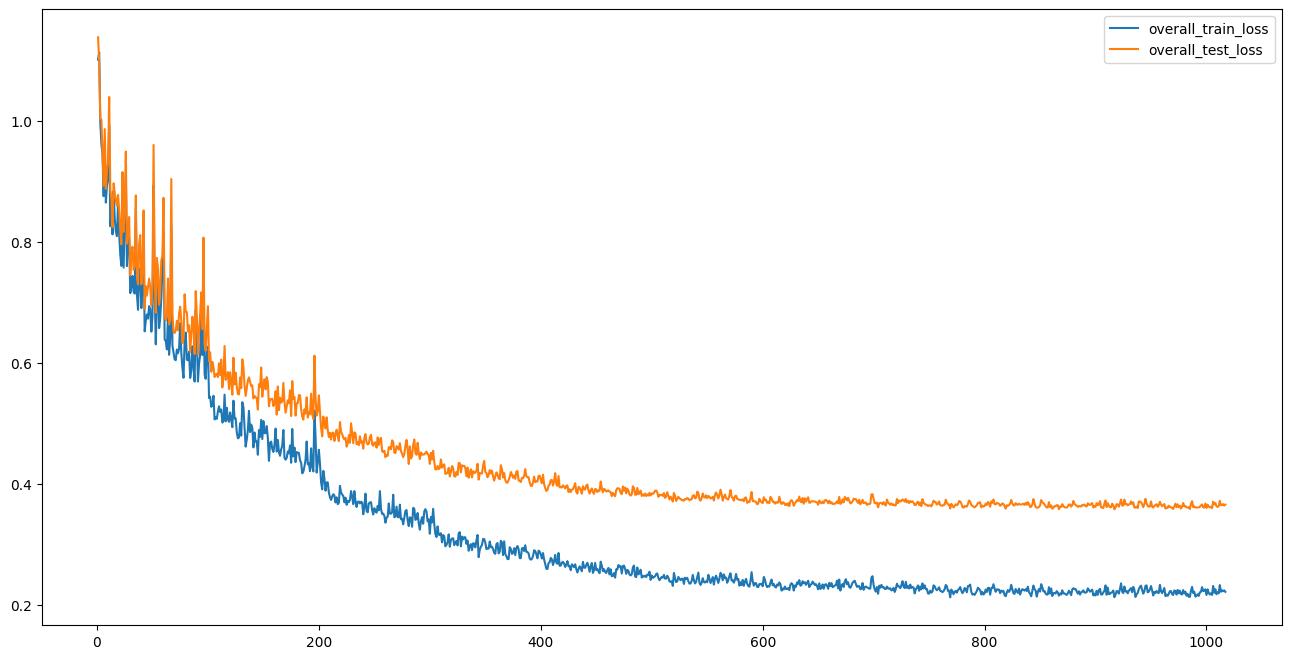

In [24]:
x = [i for i in range(1, 1018)]
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_loss, label = 'overall_train_loss')
plt.plot(x, overall_test_loss, label = 'overall_test_loss')
plt.legend()
plt.show()
# fig.savefig('./mae_no_fingerprint_GraphConv.png')

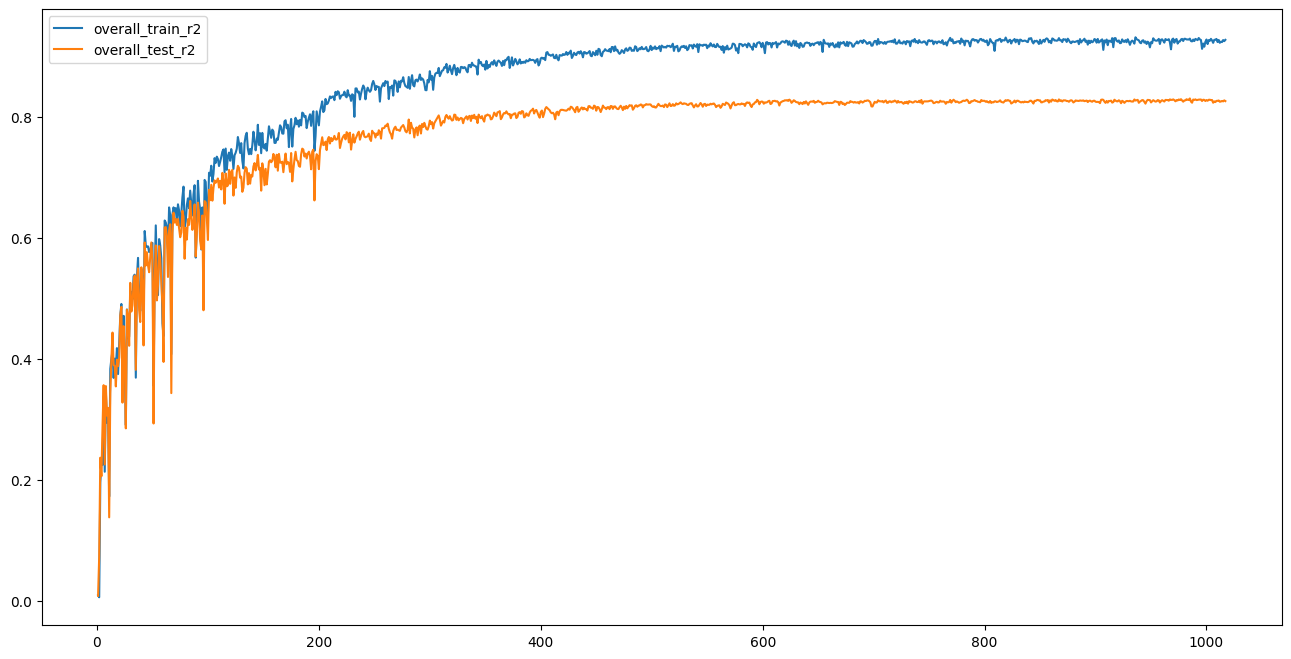

In [25]:
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_r2, label = 'overall_train_r2')
plt.plot(x, overall_test_r2, label = 'overall_test_r2')
plt.legend()
plt.show()
# fig.savefig('./r2_no_fingerprint_GraphConv.png')

# 8. Validation on BindingDB dataset

In [26]:
CheMBL = pd.read_csv('./data/raw_data_Neprilysin.csv', sep=';')
CheMBL = CheMBL.sample(frac=1, random_state=seed)
CheMBL

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
56,CHEMBL92949,NaN,NaN,397.37,1.0,1.03,29,CC(C)[C@H](NCP(=O)(O)O)C(=O)N[C@@H](Cc1c[nH]c2...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1150039,1,Scientific Literature,Bioorg Med Chem Lett,1994,NaN,NaN,NaN,NaN
282,CHEMBL37052,NaN,NaN,524.49,1.0,3.14,45,O=C(O)[C@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)[C@H](C...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1131381,1,Scientific Literature,J Med Chem,1998,NaN,NaN,NaN,NaN
289,CHEMBL10247,THIORPHAN,-1.0,253.32,0.0,0.98,DL-thiorphan,O=C(O)CNC(=O)C(CS)Cc1ccccc1,IC50,'=',...,SINGLE PROTEIN,CHEMBL3232818,1,Scientific Literature,Eur J Med Chem,2014,NaN,NaN,NaN,NaN
507,CHEMBL3677665,NaN,NaN,431.49,0.0,4.50,BDBM153112,C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,IC50,'=',...,SINGLE PROTEIN,CHEMBL3638737,37,BindingDB Database,NaN,2015,NaN,NaN,NaN,NaN
240,CHEMBL3695451,NaN,NaN,429.86,0.0,3.31,BDBM138393,C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,IC50,'=',...,SINGLE PROTEIN,CHEMBL3638481,37,BindingDB Database,NaN,2014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,CHEMBL4515703,NaN,NaN,542.15,2.0,6.65,9,CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,IC50,'=',...,SINGLE PROTEIN,CHEMBL4308919,1,Scientific Literature,ACS Med Chem Lett,2019,NaN,NaN,NaN,NaN
129,CHEMBL433702,NaN,NaN,349.50,0.0,3.24,42a,O=C1N[C@H](C(=O)O)Cc2ccccc2CCCCCCC[C@@H]1CS,IC50,'=',...,SINGLE PROTEIN,CHEMBL1130406,1,Scientific Literature,J Med Chem,1997,NaN,NaN,NaN,NaN
285,CHEMBL2029397,NaN,NaN,706.81,2.0,-4.25,"6, [Thr4]-Opiorphin",C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,IC50,'>',...,SINGLE PROTEIN,CHEMBL2029309,1,Scientific Literature,ACS Med Chem Lett,2012,NaN,NaN,NaN,NaN
485,CHEMBL4451425,NaN,NaN,652.26,2.0,8.36,17,CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2ccc(-c3ccccc3)cc2...,IC50,'=',...,SINGLE PROTEIN,CHEMBL4308919,1,Scientific Literature,ACS Med Chem Lett,2019,NaN,NaN,NaN,NaN


In [27]:
print('number of none: ', CheMBL.isna().sum())
print('number of unique: ',CheMBL.nunique())

number of none:  Molecule ChEMBL ID              0
Molecule Name                 500
Molecule Max Phase            514
Molecular Weight                0
#RO5 Violations                 1
AlogP                           1
Compound Key                    0
Smiles                          0
Standard Type                   0
Standard Relation               6
Standard Value                  6
Standard Units                  0
pChEMBL Value                  91
Data Validity Comment         520
Comment                       503
Uo Units                        0
Ligand Efficiency BEI          91
Ligand Efficiency LE           92
Ligand Efficiency LLE          92
Ligand Efficiency SEI          92
Potential Duplicate             0
Assay ChEMBL ID                 0
Assay Description               0
Assay Type                      0
BAO Format ID                   0
BAO Label                       0
Assay Organism                264
Assay Tissue ChEMBL ID        530
Assay Tissue Name             5

In [28]:
CheMBL_copy = CheMBL.dropna(subset=['Molecule ChEMBL ID', 'Standard Relation', 'Smiles', 'Standard Value'])
CheMBL_copy = CheMBL_copy.drop_duplicates(subset=['Molecule ChEMBL ID'])
CheMBL_copy = CheMBL_copy[['Molecule ChEMBL ID', 'Standard Relation', 'Smiles', 'Standard Value']].reset_index(drop=True)
# CheMBL_copy = CheMBL_copy[CheMBL_copy['Standard Relation'] == "'='"]
CheMBL_copy

,Molecule ChEMBL ID,Standard Relation,Smiles,Standard Value
0,CHEMBL92949,'=',CC(C)[C@H](NCP(=O)(O)O)C(=O)N[C@@H](Cc1c[nH]c2...,9.00
1,CHEMBL37052,'=',O=C(O)[C@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)[C@H](C...,250.00
2,CHEMBL10247,'=',O=C(O)CNC(=O)C(CS)Cc1ccccc1,1.00
3,CHEMBL3677665,'=',C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,283.00
4,CHEMBL3695451,'=',C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,2.40
...,...,...,...,...
463,CHEMBL3695453,'=',O=C(O)[C@H](CCc1ccccc1)N[C@@H](Cc1ccc(-c2cccc(...,0.20
464,CHEMBL198316,'=',O=C(N[C@H]1Cc2ccccc2C2CCC[C@H](C(=O)O)N2C1=O)[...,0.08
465,CHEMBL4515703,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,630.96
466,CHEMBL4451425,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2ccc(-c3ccccc3)cc2...,1995.26


In [29]:
CheMBL_copy.isna().sum()

Molecule ChEMBL ID    0
Standard Relation     0
Smiles                0
Standard Value        0
dtype: int64

In [30]:
CheMBL_copy.nunique()

Molecule ChEMBL ID    468
Standard Relation       3
Smiles                468
Standard Value        264
dtype: int64

In [31]:
'CHEMBL3677665' in raw_data_molecule['ChEMBL ID of Ligand'].to_list()

False

In [32]:
# CheMBL_copy[CheMBL_copy['Molecule ChEMBL ID'] == raw_data_molecule[['Molecule ChEMBL ID']]]
for idx, i in enumerate(CheMBL_copy['Molecule ChEMBL ID'].to_list()):
    if i in raw_data_molecule['ChEMBL ID of Ligand'].to_list():
        CheMBL_copy = CheMBL_copy.drop(index = idx)

CheMBL_copy

,Molecule ChEMBL ID,Standard Relation,Smiles,Standard Value
3,CHEMBL3677665,'=',C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,283.00
4,CHEMBL3695451,'=',C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,2.40
6,CHEMBL4535903,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CC(C)C)n1Cc1ccc(-c2c...,63.10
10,CHEMBL4466321,'=',N#Cc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(=O)O...,6.90
17,CHEMBL4469350,'=',CCCCc1nc(Cl)c(CNC(=O)[C@@H](S)CC(C)C)n1Cc1ccc(...,1.00
...,...,...,...,...
441,CHEMBL4534876,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2cccc3ccccc23)n1Cc...,630.96
445,CHEMBL322069,'=',CC(=O)SCC(C)C(=O)Nc1ccccc1,20000.00
463,CHEMBL3695453,'=',O=C(O)[C@H](CCc1ccccc1)N[C@@H](Cc1ccc(-c2cccc(...,0.20
465,CHEMBL4515703,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,630.96


In [33]:
pIC50_DB = CheMBL_copy['Standard Value'].apply(lambda x: -np.log10(x * 10 ** (-9) ))
pIC50_DB = pd.Series(pIC50_DB, name='pIC50')
CheMBL_copy['pIC50'] = pIC50_DB
del CheMBL_copy['Standard Value']

In [34]:
CheMBL_copy = CheMBL_copy.reset_index(drop=True)
CheMBL_copy = CheMBL_copy[CheMBL_copy['pIC50'] >= 4.0]
CheMBL_copy = CheMBL_copy.reset_index(drop=True)
CheMBL_copy

,Molecule ChEMBL ID,Standard Relation,Smiles,pIC50
0,CHEMBL3677665,'=',C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,6.548214
1,CHEMBL3695451,'=',C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,8.619789
2,CHEMBL4535903,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CC(C)C)n1Cc1ccc(-c2c...,7.199971
3,CHEMBL4466321,'=',N#Cc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(=O)O...,8.161151
4,CHEMBL4469350,'=',CCCCc1nc(Cl)c(CNC(=O)[C@@H](S)CC(C)C)n1Cc1ccc(...,9.000000
...,...,...,...,...
98,CHEMBL4534876,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2cccc3ccccc23)n1Cc...,6.199998
99,CHEMBL322069,'=',CC(=O)SCC(C)C(=O)Nc1ccccc1,4.698970
100,CHEMBL3695453,'=',O=C(O)[C@H](CCc1ccccc1)N[C@@H](Cc1ccc(-c2cccc(...,9.698970
101,CHEMBL4515703,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,6.199998


In [ ]:
graph_list_CheMBL = [smiles_to_graph(smile) for smile in CheMBL_copy['Smiles']]
pIC50_list_CheMBL = CheMBL_copy['pIC50'].to_list()

scaler = StandardScaler()
pIC50_list_CheMBL = scaler.fit_transform(np.array(pIC50_list_CheMBL).reshape(-1, 1)).flatten()

for graph, pIC50 in zip(graph_list_CheMBL, pIC50_list_CheMBL):
    graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)


drug_graphs_CheMBL = graph_list_CheMBL
drug_graphs_CheMBL[0]


Data(x=[32, 149], edge_index=[2, 68], edge_attr=[68, 10], y=[1, 1])

In [ ]:
CheMBL_loader = DataLoader(drug_graphs_CheMBL, batch_size = 1, shuffle = False)

In [ ]:
def test_DB(protein_graph, loader):
    model.eval()

    loss_list = []
    out_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)

            out = model(protein_graph, data)

            out_no_scaled = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual_no_scaled = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = torch.nn.L1Loss(reduction='mean')(out_no_scaled, actual_no_scaled)

            loss_list.append(mae_loss)
            out_list.append(out.detach().cpu().numpy())
            
    return out_list, loss_list

In [ ]:
out_list, loss_list = test_DB(protein_graph, CheMBL_loader)
print(f'the length of out_list: {len(out_list)}')
print(f'the length of out_list: {len(loss_list)}')

the length of out_list: 103
the length of out_list: 103


In [ ]:
print(f'average MAE loss: {np.average(loss_list):.4f}')
print(out_list[0][0][0])

average MAE loss: 0.4862
0.009216756


In [ ]:
out_list_modify = []
for out in out_list:
    out = out[0][0]
    out_list_modify.append(out)
out_list_modify = np.array(out_list_modify)

In [ ]:
y_pred_array = scaler.inverse_transform(out_list_modify.reshape(-1, 1)).flatten()
pIC50_pred = pd.Series(y_pred_array, name='pIC50_pred')

In [ ]:
CheMBL_copy['pIC50_pred'] = pIC50_pred
CheMBL_copy

,Molecule ChEMBL ID,Standard Relation,Smiles,pIC50,pIC50_pred
0,CHEMBL3677665,'=',C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,6.548214,7.285959
1,CHEMBL3695451,'=',C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,8.619789,9.073439
2,CHEMBL4535903,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CC(C)C)n1Cc1ccc(-c2c...,7.199971,7.167758
3,CHEMBL4466321,'=',N#Cc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(=O)O...,8.161151,8.661793
4,CHEMBL4469350,'=',CCCCc1nc(Cl)c(CNC(=O)[C@@H](S)CC(C)C)n1Cc1ccc(...,9.000000,7.665948
...,...,...,...,...,...
98,CHEMBL4534876,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2cccc3ccccc23)n1Cc...,6.199998,6.258000
99,CHEMBL322069,'=',CC(=O)SCC(C)C(=O)Nc1ccccc1,4.698970,5.061240
100,CHEMBL3695453,'=',O=C(O)[C@H](CCc1ccccc1)N[C@@H](Cc1ccc(-c2cccc(...,9.698970,9.941105
101,CHEMBL4515703,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,6.199998,6.357945


In [ ]:
x = CheMBL_copy['pIC50'].to_list()
y = CheMBL_copy['pIC50_pred'].to_list()

<function matplotlib.pyplot.show(close=None, block=None)>

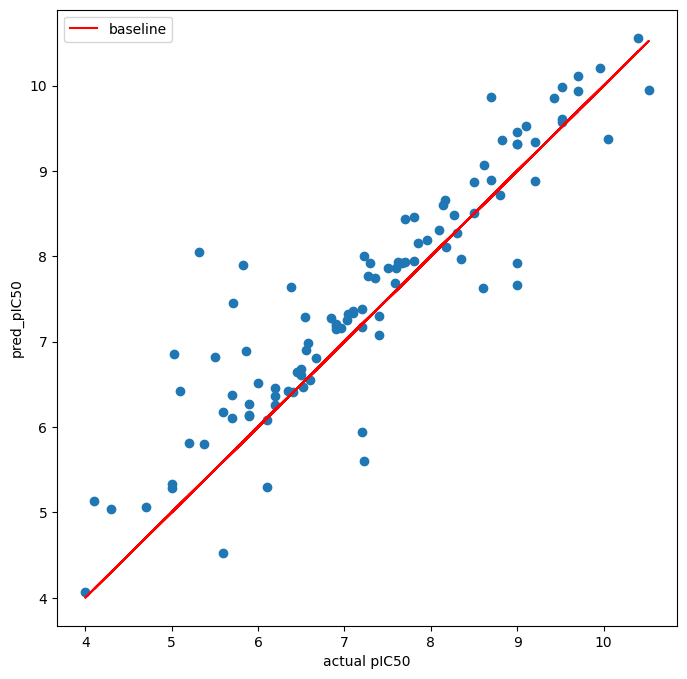

In [ ]:
y_baseline = x
fig = plt.figure(figsize=(8,8))
plt.scatter(x, y)
plt.plot(x, y_baseline, label = 'baseline', color = 'r')
plt.legend()
plt.xlabel('actual pIC50')
plt.ylabel('pred_pIC50')
plt.show

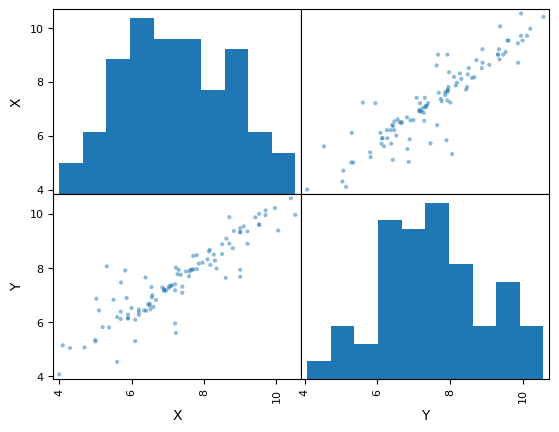

pearson系数: 0.907398728261424
P-Value: 8.250067602483563e-40


In [ ]:
pred_results = pd.DataFrame({"X":x,"Y":y})
pd.plotting.scatter_matrix(pred_results)
plt.show()

r = pearsonr(pred_results['X'],pred_results['Y'])
print("pearson系数:",r[0])
print("P-Value:",r[1])


In [ ]:
r2_score(x, y)

0.7877541744010975